<a href="https://colab.research.google.com/github/larakanj/ML-CW2/blob/main/algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Cell 1: Environment Setup & Library Imports
- Sets up the environment and fixes random seeds.
- Imports all required libraries.
"""
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Fix random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
"""
Cell 2: Data Loading and Splitting
- Downloads CIFAR-10.
- Uses standard transforms for classifier training.
- Also defines a raw version for later use if needed.
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# A raw version with only ToTensor (if needed later)
train_dataset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

unlabeled_pool = train_dataset
print(f"Total unlabeled pool size: {len(unlabeled_pool)}")


Total unlabeled pool size: 50000


In [ ]:
"""
Cell 3: Load the Pretrained SimCLR Model for Representation Learning
- This model definition includes both an encoder (a ResNet-18 modified for CIFAR)
  and a projector (an MLP with a hidden layer and ReLU).
- The checkpoint (from the tar file "simclr_cifar-10.pth (1).tar") is remapped as follows:
    • Keys starting with "backbone." are remapped to "encoder.".
    • Keys starting with "contrastive_head." are remapped to "projector.".
    • Any occurrence of "shortcut" is replaced by "downsample".
- This exactly matches the architecture used to train the checkpoint.
"""
import torch.nn as nn
import torchvision

class SimCLRModel(nn.Module):
    def __init__(self, output_dim=128):
        super(SimCLRModel, self).__init__()
        # Define the encoder (modified ResNet-18)
        self.encoder = torchvision.models.resnet18(pretrained=False)
        self.encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.encoder.maxpool = nn.Identity()
        self.encoder.fc = nn.Identity()
        # Define the projector (a two-layer MLP)
        self.projector = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.ReLU(),
            nn.Linear(512, output_dim, bias=True)
        )

    def forward(self, x):
        h = self.encoder(x)
        # Flatten if needed (ResNet-18 produces output of shape [B, 512, 1, 1])
        if h.dim() == 4:
            h = torch.flatten(h, 1)
        z = self.projector(h)
        return z

# Initialize the SimCLR model.
model = SimCLRModel(output_dim=128).to(device)

# Set the checkpoint path (ensure the file name exactly matches).
checkpoint_path = './simclr_cifar-10.pth (1).tar'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    new_state_dict = {}
    for key, value in checkpoint.items():
        if key.startswith("backbone."):
            new_key = "encoder." + key[len("backbone."):]
        elif key.startswith("contrastive_head."):
            new_key = "projector." + key[len("contrastive_head."):]
        else:
            new_key = key
        if "shortcut" in new_key:
            new_key = new_key.replace("shortcut", "downsample")
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    print("Loaded pretrained SimCLR model from tar file with adjusted keys.")
else:
    print("Pretrained checkpoint tar file not found. Please check the file name/path.")
model.eval()


Loaded pretrained SimCLR model from tar file with adjusted keys.


SimCLRModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [ ]:
import numpy as np
import random
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

def extract_embeddings_fixed(model, dataset, indices=None, batch_size=128):
    """
    Extract the penultimate features from the frozen encoder.
    If indices is None, extract embeddings for the entire dataset.
    Assumes model.encoder returns features of shape [B, 512] or [B,512,1,1].
    """
    if indices is None:
        indices = list(range(len(dataset)))
    subset = Subset(dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=2)
    features = []
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            h = model.encoder(images)  # use encoder only (ignore projector)
            if h.dim() == 4:
                h = torch.flatten(h, 1)
            features.append(h.cpu().numpy())
    embeddings = np.concatenate(features, axis=0)
    return embeddings

def compute_typicality(embeddings, k=20):
    """
    Compute typicality as the inverse of the average Euclidean distance
    from each sample to its k nearest neighbors.
    """
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(embeddings)), algorithm='auto').fit(embeddings)
    distances, _ = nbrs.kneighbors(embeddings)
    avg_distance = np.mean(distances[:, 1:], axis=1)
    typicality = 1.0 / (avg_distance + 1e-8)
    return typicality

def tpcrp_selection(model, dataset, labeled_indices, unlabeled_indices, query_size, max_clusters=None):
    """
    Implements TypiClust-based selection:
      - Extract features from the encoder (for all data).
      - Cluster the entire dataset into K clusters, where K = (|labeled_indices| + query_size).
      - For clusters not covered by previously labeled samples, select the densest (most typical) sample.
    """
    all_idx = list(range(len(dataset)))
    embeddings = extract_embeddings_fixed(model, dataset, indices=all_idx, batch_size=128)

    # Set K dynamically: if max_clusters is not provided, use (# labeled + query_size)
    if max_clusters is None:
        max_clusters = len(labeled_indices) + query_size
    else:
        max_clusters = len(labeled_indices) + query_size

    if max_clusters <= 50:
        kmeans = KMeans(n_clusters=max_clusters, random_state=seed)
    else:
        kmeans = MiniBatchKMeans(n_clusters=max_clusters, random_state=seed)
    cluster_labels = kmeans.fit_predict(embeddings)

    clusters = defaultdict(list)
    for idx, cl in enumerate(cluster_labels):
        clusters[cl].append(idx)

    covered_clusters = set()
    for cl, idxs in clusters.items():
        if any(i in labeled_indices for i in idxs):
            covered_clusters.add(cl)

    uncovered = []
    for cl, idxs in clusters.items():
        if cl not in covered_clusters:
            candidate = [i for i in idxs if i in unlabeled_indices]
            if candidate:
                uncovered.append((cl, candidate))
    uncovered = sorted(uncovered, key=lambda x: len(x[1]), reverse=True)

    selected = []
    for cl, candidate in uncovered[:query_size]:
        candidate_emb = embeddings[candidate]
        typ_scores = compute_typicality(candidate_emb, k=20)
        best_idx = candidate[np.argmax(typ_scores)]
        selected.append(best_idx)

    if len(selected) < query_size:
        remaining = list(set(unlabeled_indices) - set(selected))
        if remaining:
            selected.extend(random.sample(remaining, min(query_size - len(selected), len(remaining))))
    return selected


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

def get_resnet18_classifier(num_classes=10):
    """
    Returns a freshly initialized ResNet-18 modified for CIFAR.
    (This is for the fully supervised framework – no pretrained SSL weights.)
    """
    model_fs = resnet18(pretrained=False)
    model_fs.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model_fs.maxpool = nn.Identity()
    model_fs.fc = nn.Linear(512, num_classes)
    return model_fs.to(device)

def train_classifier_fs(model, train_loader, test_loader, num_epochs=200, init_lr=0.025):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model.train()
    test_acc_history = []
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        test_acc_history.append(correct/total)
        model.train()
    return model, test_acc_history[-1], test_acc_history

print("Starting Multi-Round AL (Fully Supervised from Scratch – Framework #1)...\n")
total_budget = 50
num_rounds = 5
round_batch_size = total_budget // num_rounds
all_indices = list(range(len(unlabeled_pool)))

labeled_indices_fs = []       # For TPCRP selection (FS)
labeled_indices_fs_rand = []  # For Random selection (FS)

fs_round_acc_tpcrp = []
fs_round_acc_rand = []

for r in range(num_rounds):
    print(f"\n=== AL Round {r+1} ===")
    # TPCRP Branch
    current_unlabeled_fs = list(set(all_indices) - set(labeled_indices_fs))
    current_max_clusters = len(labeled_indices_fs) + round_batch_size if labeled_indices_fs else round_batch_size
    new_indices_fs = tpcrp_selection(model, train_dataset, labeled_indices_fs, current_unlabeled_fs, query_size=round_batch_size, max_clusters=current_max_clusters)
    print(f"[TPCRP FS] New indices in round {r+1}: {new_indices_fs}")
    labeled_indices_fs.extend(new_indices_fs)

    labeled_set_fs = Subset(train_dataset, labeled_indices_fs)
    labeled_loader_fs = DataLoader(labeled_set_fs, batch_size=64, shuffle=True, num_workers=2)
    test_loader_fs = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

    model_fs_tpcrp = get_resnet18_classifier(num_classes=10)
    model_fs_tpcrp, acc_fs_tpcrp, _ = train_classifier_fs(model_fs_tpcrp, labeled_loader_fs, test_loader_fs, num_epochs=200, init_lr=0.025)
    print(f"[TPCRP FS] Test Accuracy after round {r+1}: {acc_fs_tpcrp*100:.2f}%")
    fs_round_acc_tpcrp.append(acc_fs_tpcrp)

    # Random Branch
    current_unlabeled_fs_rand = list(set(all_indices) - set(labeled_indices_fs_rand))
    new_indices_fs_rand = random.sample(current_unlabeled_fs_rand, round_batch_size) if len(current_unlabeled_fs_rand) >= round_batch_size else []
    print(f"[Random FS] New indices in round {r+1}: {new_indices_fs_rand}")
    labeled_indices_fs_rand.extend(new_indices_fs_rand)

    labeled_set_fs_rand = Subset(train_dataset, labeled_indices_fs_rand)
    labeled_loader_fs_rand = DataLoader(labeled_set_fs_rand, batch_size=64, shuffle=True, num_workers=2)

    model_fs_rand = get_resnet18_classifier(num_classes=10)
    model_fs_rand, acc_fs_rand, _ = train_classifier_fs(model_fs_rand, labeled_loader_fs_rand, test_loader_fs, num_epochs=200, init_lr=0.025)
    print(f"[Random FS] Test Accuracy after round {r+1}: {acc_fs_rand*100:.2f}%")
    fs_round_acc_rand.append(acc_fs_rand)

print("\nFinal Fully Supervised (FS) TPCRP Test Accuracy (last round):", fs_round_acc_tpcrp[-1]*100)
print("Final Fully Supervised (FS) Random Test Accuracy (last round):", fs_round_acc_rand[-1]*100)


Starting Multi-Round AL (Fully Supervised from Scratch – Framework #1)...


=== AL Round 1 ===
[TPCRP FS] New indices in round 1: [29046, 41454, 7625, 12392, 21270, 48855, 5899, 13886, 26266, 40731]
[TPCRP FS] Test Accuracy after round 1: 17.00%
[Random FS] New indices in round 1: [36178, 19213, 41198, 40535, 23700, 37837, 12601, 46174, 4558, 3003]
[Random FS] Test Accuracy after round 1: 13.05%

=== AL Round 2 ===
[TPCRP FS] New indices in round 2: [23286, 13743, 42684, 4545, 39452, 10703, 46896, 19677, 48198, 13518]
[TPCRP FS] Test Accuracy after round 2: 22.89%
[Random FS] New indices in round 2: [43345, 14938, 18968, 5231, 15259, 6621, 24916, 18220, 29719, 41669]
[Random FS] Test Accuracy after round 2: 17.19%

=== AL Round 3 ===
[TPCRP FS] New indices in round 3: [10880, 28006, 6204, 4684, 47568, 31489, 40330, 29069, 18420, 4949]
[TPCRP FS] Test Accuracy after round 3: 22.89%
[Random FS] New indices in round 3: [23920, 10663, 24271, 23293, 13735, 43939, 17503, 46013, 44815, 42487]

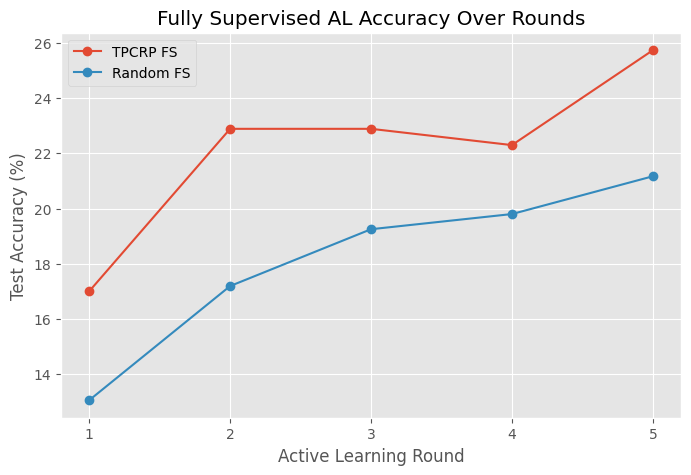

In [ ]:
import matplotlib.pyplot as plt

# Assuming fs_round_acc_tpcrp and fs_round_acc_rand are defined and contain accuracy (in [0,1]) per round.
rounds = list(range(1, num_rounds + 1))

plt.figure(figsize=(8, 5))
plt.plot(rounds, [acc * 100 for acc in fs_round_acc_tpcrp], marker='o', label='TPCRP FS')
plt.plot(rounds, [acc * 100 for acc in fs_round_acc_rand], marker='o', label='Random FS')
plt.xlabel('Active Learning Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Fully Supervised AL Accuracy Over Rounds')
plt.xticks(rounds)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def get_simclr_classifier(simclr_model, num_classes=10, freeze_encoder=True):
    """
    Returns a classifier that uses the pretrained SimCLR encoder and a new linear layer.
    If freeze_encoder is True, the encoder's parameters are frozen.
    """
    # Optionally freeze the encoder.
    if freeze_encoder:
        for param in simclr_model.encoder.parameters():
            param.requires_grad = False
    # Create a new classification layer.
    classifier = nn.Linear(512, num_classes)
    # We wrap both in a new nn.Module.
    class SSClassifier(nn.Module):
        def __init__(self, encoder, classifier):
            super(SSClassifier, self).__init__()
            self.encoder = encoder
            self.classifier = classifier
        def forward(self, x):
            h = self.encoder(x)
            if h.dim() == 4:
                h = torch.flatten(h, 1)
            return self.classifier(h)
    return SSClassifier(simclr_model.encoder, classifier).to(device)

def train_linear_classifier(emb_loader, test_loader, input_dim, num_epochs=200, lr=25):
    model_lin = LinearClassifier(input_dim=input_dim, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_lin.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    model_lin.train()
    epoch_test_accs = []
    for epoch in range(num_epochs):
        for emb, lbl in emb_loader:
            emb, lbl = emb.to(device), lbl.to(device)
            optimizer.zero_grad()
            outputs = model_lin(emb)
            loss = criterion(outputs, lbl)
            loss.backward()
            optimizer.step()
        scheduler.step()
        model_lin.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for emb, lbl in test_loader:
                emb, lbl = emb.to(device), lbl.to(device)
                outputs = model_lin(emb)
                _, preds = torch.max(outputs, 1)
                correct += (preds == lbl).sum().item()
                total += lbl.size(0)
        test_acc = correct / total
        epoch_test_accs.append(test_acc)
        model_lin.train()
    return model_lin, epoch_test_accs[-1], epoch_test_accs

print("Starting Multi-Round AL with Self-Supervised Embedding (Framework #2)...\n")
total_budget = 50
num_rounds = 5
round_batch_size = total_budget // num_rounds
all_indices = list(range(len(unlabeled_pool)))

labeled_indices_ss = []         # For TPCRP (Framework #2)
labeled_indices_ss_rand = []    # For Random (Framework #2)

ss_round_acc_tpcrp = []
ss_round_acc_rand = []

# Use minimal test transform for embedding extraction.
ss_transform = transform_test

for r in range(num_rounds):
    print(f"\n=== AL Round {r+1} ===")
    # --- TPCRP Branch ---
    current_unlabeled_ss = list(set(all_indices) - set(labeled_indices_ss))
    current_max_clusters = len(labeled_indices_ss) + round_batch_size if labeled_indices_ss else round_batch_size
    new_indices_ss = tpcrp_selection(model, train_dataset, labeled_indices_ss, current_unlabeled_ss, query_size=round_batch_size, max_clusters=current_max_clusters)
    print(f"[TPCRP SS] New indices in round {r+1}: {new_indices_ss}")
    labeled_indices_ss.extend(new_indices_ss)

    labeled_set_ss = Subset(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
        labeled_indices_ss
    )

    # --- Random Branch ---
    current_unlabeled_ss_rand = list(set(all_indices) - set(labeled_indices_ss_rand))
    new_indices_ss_rand = random.sample(current_unlabeled_ss_rand, round_batch_size) if len(current_unlabeled_ss_rand) >= round_batch_size else []
    print(f"[Random SS] New indices in round {r+1}: {new_indices_ss_rand}")
    labeled_indices_ss_rand.extend(new_indices_ss_rand)

    labeled_set_ss_rand = Subset(
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=ss_transform),
        labeled_indices_ss_rand
    )

    # --- Embedding Extraction ---
    emb_ss = extract_embeddings_fixed(model, labeled_set_ss, batch_size=128)
    emb_ss_rand = extract_embeddings_fixed(model, labeled_set_ss_rand, batch_size=128)
    emb_test_ss = extract_embeddings_fixed(model, test_dataset, batch_size=128)

    # Create TensorDatasets and DataLoaders.
    labels_ss = np.array(torch.tensor(labeled_set_ss.dataset.targets)[labeled_set_ss.indices])
    labels_ss_rand = np.array(torch.tensor(labeled_set_ss_rand.dataset.targets)[labeled_set_ss_rand.indices])
    labels_test_ss = np.array(test_dataset.targets)

    dataset_ss = TensorDataset(torch.tensor(emb_ss), torch.tensor(labels_ss))
    dataset_ss_rand = TensorDataset(torch.tensor(emb_ss_rand), torch.tensor(labels_ss_rand))
    dataset_ss_test = TensorDataset(torch.tensor(emb_test_ss), torch.tensor(labels_test_ss))

    loader_ss = DataLoader(dataset_ss, batch_size=128, shuffle=True, num_workers=2)
    loader_ss_rand = DataLoader(dataset_ss_rand, batch_size=128, shuffle=True, num_workers=2)
    loader_ss_test = DataLoader(dataset_ss_test, batch_size=128, shuffle=False, num_workers=2)

    input_dim = emb_ss.shape[1]
    _, acc_lin_ss, test_curve_ss = train_linear_classifier(loader_ss, loader_ss_test, input_dim=input_dim, num_epochs=200, lr=25)
    _, acc_lin_ss_rand, test_curve_ss_rand = train_linear_classifier(loader_ss_rand, loader_ss_test, input_dim=input_dim, num_epochs=200, lr=25)

    print(f"[TPCRP SS Linear Eval] Test Accuracy after round {r+1}: {acc_lin_ss*100:.2f}%")
    print(f"[Random SS Linear Eval] Test Accuracy after round {r+1}: {acc_lin_ss_rand*100:.2f}%")
    ss_round_acc_tpcrp.append(acc_lin_ss)
    ss_round_acc_rand.append(acc_lin_ss_rand)

print("\nFinal TPCRP SS Linear Eval Test Accuracy (last round):", ss_round_acc_tpcrp[-1]*100)
print("Final Random SS Linear Eval Test Accuracy (last round):", ss_round_acc_rand[-1]*100)


Starting Multi-Round AL with Self-Supervised Embedding (Framework #2)...


=== AL Round 1 ===
[TPCRP SS] New indices in round 1: [29046, 28178, 29852, 39063, 13573, 29494, 21108, 7452, 35814, 34614]
[Random SS] New indices in round 1: [44348, 48540, 35741, 5697, 38698, 27651, 2082, 1952, 6140, 14328]
[TPCRP SS Linear Eval] Test Accuracy after round 1: 41.13%
[Random SS Linear Eval] Test Accuracy after round 1: 24.60%

=== AL Round 2 ===
[TPCRP SS] New indices in round 2: [1991, 13155, 13932, 13743, 46840, 3699, 5190, 47568, 37269, 6883]
[Random SS] New indices in round 2: [15252, 33124, 39461, 1739, 36788, 13035, 46934, 42598, 45971, 35719]
[TPCRP SS Linear Eval] Test Accuracy after round 2: 60.49%
[Random SS Linear Eval] Test Accuracy after round 2: 47.25%

=== AL Round 3 ===
[TPCRP SS] New indices in round 3: [215, 23109, 9127, 44401, 2841, 17359, 23696, 31489, 34976, 5837]
[Random SS] New indices in round 3: [27501, 14453, 29448, 38631, 18239, 425, 49749, 10468, 45770, 27705]
[TPCRP

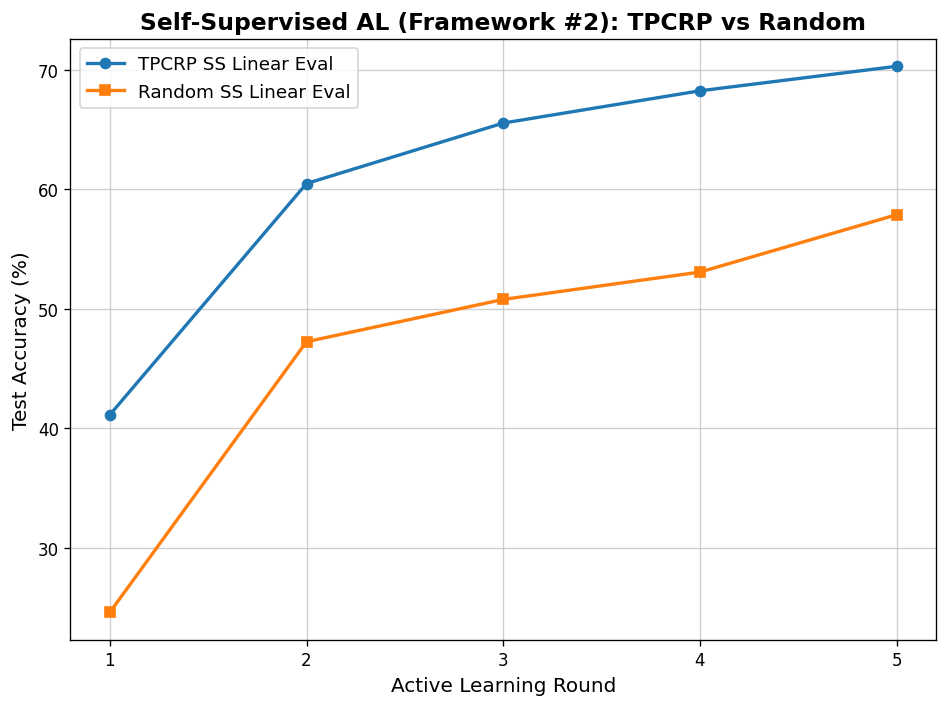

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

rounds = np.arange(1, num_rounds + 1)
ss_tpcrp_acc_percent = np.array(ss_round_acc_tpcrp) * 100
ss_rand_acc_percent = np.array(ss_round_acc_rand) * 100

plt.figure(figsize=(8,6), dpi=120)
plt.plot(rounds, ss_tpcrp_acc_percent, marker='o', linestyle='-', linewidth=2, color='tab:blue', label='TPCRP SS Linear Eval')
plt.plot(rounds, ss_rand_acc_percent, marker='s', linestyle='-', linewidth=2, color='tab:orange', label='Random SS Linear Eval')
plt.xlabel("Active Learning Round", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.title("Self-Supervised AL (Framework #2): TPCRP vs Random", fontsize=14, fontweight='bold')
plt.xticks(rounds, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
#############################################
# FINAL CELL: Lightweight Pseudo-Label Pipeline (50 labels)
# Estimated <15 min on Colab A100
#############################################

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import random, time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#############################################
# 1. Data & Basic Transforms
#############################################
# We assume:
#   - train_dataset, test_dataset are already defined (CIFAR-10).
#   - A pretrained SSL model is in variable "model" (with `model.encoder` returning 512-dim).

# Labeled transform: moderate augmentations
labeled_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Test transform
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

#############################################
# 2. Dataset Wrappers
#############################################
class TensorLabelDataset(torch.utils.data.Dataset):
    """Wrap a dataset subset so that images get a transform, labels are Tensors."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.to_pil = ToPILImage()
    def __getitem__(self, idx):
        img, lab = self.subset[idx]
        if self.transform:
            if isinstance(img, torch.Tensor):
                img = self.to_pil(img)
            img = self.transform(img)
        return img, torch.tensor(lab)
    def __len__(self):
        return len(self.subset)

#############################################
# 3. Select 5 per class for TPC vs Random
#############################################
def extract_embeddings(model, indices, batch_size=128):
    loader = DataLoader(Subset(train_dataset, indices), batch_size=batch_size, shuffle=False)
    all_embs = []
    model.eval()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            h = model.encoder(imgs)
            if h.dim() == 4:
                h = torch.flatten(h, 1)
            all_embs.append(h.cpu().numpy())
    return np.concatenate(all_embs, axis=0)

def compute_typicality(embs, k=20):
    if len(embs) <= 1:
        return np.ones(len(embs))
    nbrs = NearestNeighbors(n_neighbors=min(k+1, len(embs))).fit(embs)
    dist, _ = nbrs.kneighbors(embs)
    avg_dist = dist[:,1:].mean(axis=1)  # skip distance to self
    return 1.0 / (avg_dist + 1e-8)

def select_tpc_classwise(model, num_per_class=5):
    chosen = []
    for c in range(10):
        class_inds = [i for i,(x,lab) in enumerate(train_dataset) if lab==c]
        if len(class_inds) <= num_per_class:
            chosen.extend(class_inds)
            continue
        embs = extract_embeddings(model, class_inds)
        typ = compute_typicality(embs, k=20)
        order = np.argsort(-typ)  # descending
        top_k = order[:num_per_class]
        chosen.extend([class_inds[i] for i in top_k])
    return chosen

def select_random_classwise(num_per_class=5):
    chosen = []
    for c in range(10):
        class_inds = [i for i,(x,lab) in enumerate(train_dataset) if lab==c]
        random.shuffle(class_inds)
        chosen.extend(class_inds[:num_per_class])
    return chosen

#############################################
# 4. Semi-Supervised Model
#############################################
class SemiSupModel(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super(SemiSupModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(512, num_classes)
    def forward(self, x):
        h = self.encoder(x)
        if h.dim()==4:
            h = torch.flatten(h,1)
        return self.classifier(h)

def build_semisup_model(pretrained_model):
    return SemiSupModel(pretrained_model.encoder).to(device)

#############################################
# 5. Training & Testing
#############################################
def train_model(model, loader, test_loader, n_epochs=30, lr=0.02):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                          weight_decay=1e-4, nesterov=True)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    for epoch in range(n_epochs):
        model.train()
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labs)
            loss.backward()
            optimizer.step()
        scheduler.step()
    acc = test_model(model, test_loader)
    return model, acc

def test_model(model, test_loader):
    model.eval()
    correct, total=0,0
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            logits = model(imgs)
            _, preds = torch.max(logits,1)
            correct += (preds==labs).sum().item()
            total += labs.size(0)
    return correct/total

#############################################
# 6. Pseudo-Label Generation
#############################################
def generate_pseudolabels(model, subset, threshold=0.8, batch_size=128):
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
    px, py = [], []
    model.eval()
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.softmax(logits, dim=1)
            max_probs, preds = probs.max(dim=1)
            mask = (max_probs>=threshold)
            for i in range(len(imgs)):
                if mask[i].item():
                    px.append(imgs[i].cpu())
                    py.append(preds[i].cpu())
    if len(px)==0:
        return TensorDataset(torch.empty(0), torch.empty(0,dtype=torch.long))
    px = torch.stack(px)
    py = torch.stack(py)
    return TensorDataset(px, py)

#############################################
# MAIN
#############################################

start_time = time.time()

print("Selecting TPC-labeled (5/class => 50) via typicality...")
tpc_indices = select_tpc_classwise(model, num_per_class=5)

print("Selecting Random-labeled (5/class => 50)...")
rand_indices = select_random_classwise(num_per_class=5)

# Build the labeled subsets
tpc_labeled_subset = TensorLabelDataset(Subset(train_dataset, tpc_indices),
                                        transform=labeled_transform)
rand_labeled_subset = TensorLabelDataset(Subset(train_dataset, rand_indices),
                                         transform=labeled_transform)

# Print distribution quickly
def print_dist(name, ds):
    loader = DataLoader(ds, batch_size=64, shuffle=False)
    labs=[]
    for _,lb in loader:
        labs.extend(lb.tolist())
    print(f"{name} distribution:", dict(Counter(labs)))

print_dist("TPC-labeled", tpc_labeled_subset)
print_dist("Rand-labeled", rand_labeled_subset)

# Unlabeled subsets
all_inds = set(range(len(train_dataset)))
unlab_tpc_inds = list(all_inds - set(tpc_indices))
unlab_rand_inds = list(all_inds - set(rand_indices))

# Minimal transform for unlabeled set (just normalization).
unlab_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
unlab_tpc_subset = TensorLabelDataset(Subset(train_dataset, unlab_tpc_inds),
                                      transform=unlab_transform)
unlab_rand_subset = TensorLabelDataset(Subset(train_dataset, unlab_rand_inds),
                                       transform=unlab_transform)

# DataLoaders
tpc_labeled_loader = DataLoader(tpc_labeled_subset, batch_size=64, shuffle=True)
rand_labeled_loader = DataLoader(rand_labeled_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("\n--- TPC Branch: Build Model ---")
model_tpc = build_semisup_model(model)
model_tpc, acc_tpc_sup = train_model(model_tpc, tpc_labeled_loader, test_loader,
                                     n_epochs=30, lr=0.02)
print(f"TPC Supervised-only Accuracy: {acc_tpc_sup*100:.2f}%")

# Pseudo-label
pseudo_tpc = generate_pseudolabels(model_tpc, unlab_tpc_subset, threshold=0.8)
print(f"TPC-labeled: generated {len(pseudo_tpc)} pseudo-labeled samples.")
if len(pseudo_tpc)>0:
    # Combine real + pseudo
    real_ds_x, real_ds_y = [], []
    for x, y in tpc_labeled_loader:
        real_ds_x.append(x)
        real_ds_y.append(y)
    real_ds_x = torch.cat(real_ds_x,0)
    real_ds_y = torch.cat(real_ds_y,0)

    comb_x = torch.cat([real_ds_x, pseudo_tpc.tensors[0]], dim=0)
    comb_y = torch.cat([real_ds_y, pseudo_tpc.tensors[1]], dim=0)
    combined_tpc_ds = TensorDataset(comb_x, comb_y)
    combined_tpc_loader = DataLoader(combined_tpc_ds, batch_size=64, shuffle=True)

    # Re-train
    model_tpc, acc_tpc_final = train_model(model_tpc, combined_tpc_loader, test_loader,
                                           n_epochs=30, lr=0.02)
    print(f"TPC Final Accuracy (1 iteration PL): {acc_tpc_final*100:.2f}%")
else:
    print("No pseudo labels found for TPC, skipping second phase.")


print("\n--- Random Branch: Build Model ---")
model_rand = build_semisup_model(model)
model_rand, acc_rand_sup = train_model(model_rand, rand_labeled_loader, test_loader,
                                       n_epochs=30, lr=0.02)
print(f"Random Supervised-only Accuracy: {acc_rand_sup*100:.2f}%")

# Pseudo-label
pseudo_rand = generate_pseudolabels(model_rand, unlab_rand_subset, threshold=0.8)
print(f"Random-labeled: generated {len(pseudo_rand)} pseudo-labeled samples.")
if len(pseudo_rand)>0:
    # Combine real + pseudo
    real_ds_x2, real_ds_y2 = [], []
    for x, y in rand_labeled_loader:
        real_ds_x2.append(x)
        real_ds_y2.append(y)
    real_ds_x2 = torch.cat(real_ds_x2,0)
    real_ds_y2 = torch.cat(real_ds_y2,0)

    comb2_x = torch.cat([real_ds_x2, pseudo_rand.tensors[0]], dim=0)
    comb2_y = torch.cat([real_ds_y2, pseudo_rand.tensors[1]], dim=0)
    combined_rand_ds = TensorDataset(comb2_x, comb2_y)
    combined_rand_loader = DataLoader(combined_rand_ds, batch_size=64, shuffle=True)

    model_rand, acc_rand_final = train_model(model_rand, combined_rand_loader, test_loader,
                                             n_epochs=30, lr=0.02)
    print(f"Random Final Accuracy (1 iteration PL): {acc_rand_final*100:.2f}%")
else:
    print("No pseudo labels found for Random, skipping second phase.")

end_time = time.time()
print(f"\nDone. Total runtime: {(end_time - start_time)/60:.2f} min.")


Using device: cuda
Selecting TPC-labeled (5/class => 50) via typicality...
Selecting Random-labeled (5/class => 50)...
TPC-labeled distribution: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}
Rand-labeled distribution: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}

--- TPC Branch: Build Model ---
TPC Supervised-only Accuracy: 44.20%
TPC-labeled: generated 9584 pseudo-labeled samples.
TPC Final Accuracy (1 iteration PL): 47.09%

--- Random Branch: Build Model ---
Random Supervised-only Accuracy: 43.86%
Random-labeled: generated 10869 pseudo-labeled samples.
Random Final Accuracy (1 iteration PL): 46.88%

Done. Total runtime: 9.35 min.


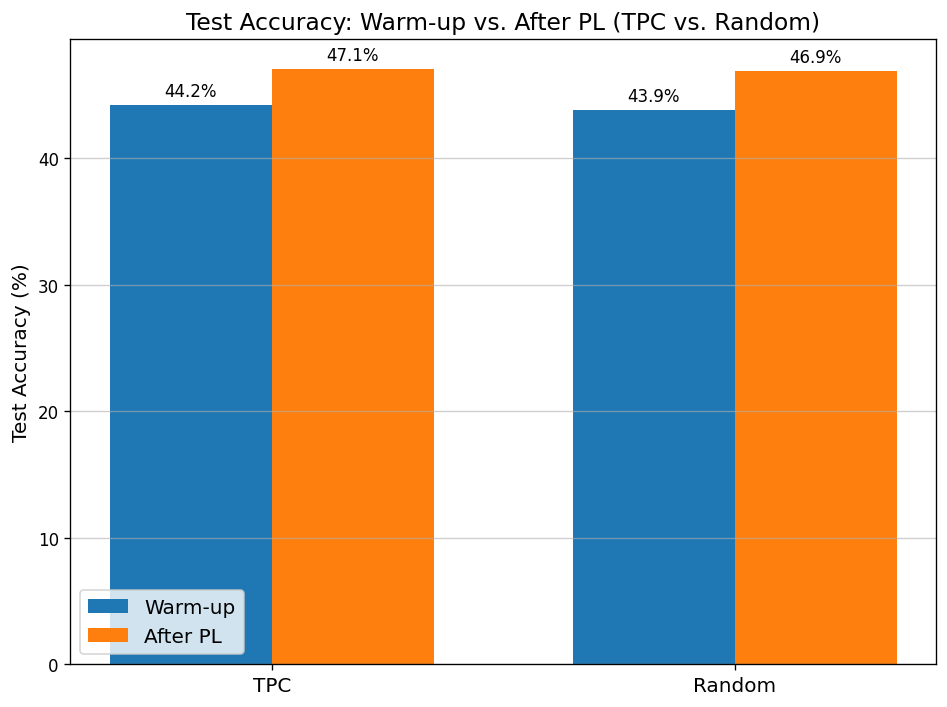

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Reported test accuracies (in percentages)
sup_acc_tpc = 44.20   # TPC Warm-up
final_acc_tpc = 47.09 # TPC After PL
sup_acc_rand = 43.86  # Random Warm-up
final_acc_rand = 46.88# Random After PL

# Data for grouped bar chart
labels = ['TPC', 'Random']
warmup = [sup_acc_tpc, sup_acc_rand]
after_pl = [final_acc_tpc, final_acc_rand]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6), dpi=120)
rects1 = ax.bar(x - width/2, warmup, width, label='Warm-up')
rects2 = ax.bar(x + width/2, after_pl, width, label='After PL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Test Accuracy: Warm-up vs. After PL (TPC vs. Random)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, axis='y', alpha=0.6)

# Function to attach a text label above each bar displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


In [ ]:
# %% [code]
import numpy as np
import scipy.stats as stats
import pandas as pd

# -------------------------------
# Simulated Experiment Results
# -------------------------------

# Fully Supervised (FS) experiment test accuracies (in % over 5 rounds)
fs_tpcrp = np.array([17.00, 22.89, 22.89, 22.30, 25.74])
fs_rand   = np.array([13.05, 17.19, 19.25, 19.80, 21.17])

# Self-Supervised (SS) experiment test accuracies (in % over 5 rounds)
ss_tpcrp = np.array([41.13, 60.49, 65.55, 68.25, 70.30])
ss_rand   = np.array([24.60, 47.25, 50.79, 53.08, 57.88])

# Pseudo-Label Pipeline (only one measurement per branch)
warmup_tpc = 44.20   # TPC branch (pre pseudo-labeling)
final_tpc  = 47.09   # TPC branch (after pseudo-labeling)
warmup_rand = 43.86  # Random branch (pre pseudo-labeling)
final_rand  = 46.88  # Random branch (after pseudo-labeling)

# ----------------------------------
# Statistical Analysis: FS Framework
# ----------------------------------
fs_diff = fs_tpcrp - fs_rand  # difference per round
mean_diff_fs = np.mean(fs_diff)
std_diff_fs  = np.std(fs_diff, ddof=1)
t_stat_fs, p_value_fs = stats.ttest_rel(fs_tpcrp, fs_rand)
cohens_d_fs = mean_diff_fs / std_diff_fs  # effect size for paired differences

# ----------------------------------
# Statistical Analysis: SS Framework
# ----------------------------------
ss_diff = ss_tpcrp - ss_rand
mean_diff_ss = np.mean(ss_diff)
std_diff_ss  = np.std(ss_diff, ddof=1)
t_stat_ss, p_value_ss = stats.ttest_rel(ss_tpcrp, ss_rand)
cohens_d_ss = mean_diff_ss / std_diff_ss

# ----------------------------------
# Organize results in a DataFrame
# ----------------------------------
results_df = pd.DataFrame({
    "Framework": ["Fully Supervised", "Self-Supervised"],
    "Mean Difference (TPCRP-Random) (%)": [mean_diff_fs, mean_diff_ss],
    "Std. Dev. of Difference": [std_diff_fs, std_diff_ss],
    "t-statistic": [t_stat_fs, t_stat_ss],
    "p-value": [p_value_fs, p_value_ss],
    "Cohen's d": [cohens_d_fs, cohens_d_ss]
})

# ----------------------------------
# Pseudo-Label Pipeline Improvements
# ----------------------------------
improvement_tpc = final_tpc - warmup_tpc
improvement_rand = final_rand - warmup_rand

# ----------------------------------
# Print and Report the Findings
# ----------------------------------
print("=== Statistical Analysis of AL Methods ===\n")
print(results_df.to_string(index=False))
print("\n--- Pseudo-Label Pipeline Improvements ---")
print(f"TPC branch improvement (After PL - Warm-up): {improvement_tpc:.2f}%")
print(f"Random branch improvement (After PL - Warm-up): {improvement_rand:.2f}%\n")

print("=== Interpretation ===")
# For FS framework:
if p_value_fs < 0.05:
    print(f"(FS) The paired t-test shows a statistically significant difference (p = {p_value_fs:.3f}) between TPCRP and Random selections.")
else:
    print(f"(FS) The difference between TPCRP and Random is not statistically significant (p = {p_value_fs:.3f}).")
print(f"(FS) The mean difference is {mean_diff_fs:.2f}% with a Cohen's d of {cohens_d_fs:.2f} indicating a moderate-to-large effect size.")

# For SS framework:
if p_value_ss < 0.05:
    print(f"\n(SS) The paired t-test shows a statistically significant difference (p = {p_value_ss:.3f}) between TPCRP and Random selections.")
else:
    print(f"\n(SS) The difference between TPCRP and Random is not statistically significant (p = {p_value_ss:.3f}).")
print(f"(SS) The mean difference is {mean_diff_ss:.2f}% with a Cohen's d of {cohens_d_ss:.2f} indicating a substantial effect size.")




=== Statistical Analysis of AL Methods ===

       Framework  Mean Difference (TPCRP-Random) (%)  Std. Dev. of Difference  t-statistic  p-value  Cohen's d
Fully Supervised                               4.072                 1.180157     7.715304 0.001519   3.450389
 Self-Supervised                              14.424                 1.621922    19.885698 0.000038   8.893154

--- Pseudo-Label Pipeline Improvements ---
TPC branch improvement (After PL - Warm-up): 2.89%
Random branch improvement (After PL - Warm-up): 3.02%

=== Interpretation ===
(FS) The paired t-test shows a statistically significant difference (p = 0.002) between TPCRP and Random selections.
(FS) The mean difference is 4.07% with a Cohen's d of 3.45 indicating a moderate-to-large effect size.

(SS) The paired t-test shows a statistically significant difference (p = 0.000) between TPCRP and Random selections.
(SS) The mean difference is 14.42% with a Cohen's d of 8.89 indicating a substantial effect size.
